In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests
import json
import re
import os
import math
from maayanlab_bioinformatics.harmonization.ncbi_genes import ncbi_genes_lookup

In [2]:
gene_lookup = ncbi_genes_lookup()

In [3]:
df = pd.read_csv("../data/41586_2022_5575_MOESM5_ESM/Supplementary Table 3-Table 1.tsv", sep="\t")

In [4]:
kinases = [i for i in df.columns if "_percentile" in i and i != "median_percentile"]
columns = ["Protein", "Gene"] + kinases

In [5]:
df = df[columns]
df.head()

,Protein,Gene,AAK1_percentile,ACVR2A_percentile,ACVR2B_percentile,AKT1_percentile,AKT2_percentile,AKT3_percentile,ALK2_percentile,ALK4_percentile,...,VRK1_percentile,VRK2_percentile,WNK1_percentile,WNK3_percentile,WNK4_percentile,YANK2_percentile,YANK3_percentile,YSK1_percentile,YSK4_percentile,ZAK_percentile
0,A0A075B6Q4,NaN,0.47,74.44,83.75,40.80,33.48,33.87,88.45,72.01,...,30.69,8.06,52.70,62.29,40.63,32.83,31.77,16.17,65.22,38.69
1,A0A075B6Q4,NaN,22.55,79.51,83.59,14.92,14.63,18.58,92.46,62.42,...,13.28,8.57,15.44,26.16,11.66,54.85,40.65,2.34,14.99,0.78
2,A0A075B6Q4,NaN,4.22,90.58,93.27,12.36,8.18,6.02,88.18,43.07,...,11.14,3.85,13.65,37.74,12.04,93.60,66.93,14.60,61.21,47.62
3,A0A075B6Q4,NaN,52.67,95.24,94.46,56.05,55.90,56.53,92.37,97.98,...,71.79,40.39,51.63,85.37,78.68,91.31,73.52,76.66,90.57,82.24
4,A0A075B6Q4,NaN,25.22,60.68,69.21,56.89,29.80,38.44,54.40,28.66,...,88.47,50.70,59.56,91.74,73.35,83.93,53.65,74.42,53.19,74.98


In [6]:
df.shape

(89784, 305)

In [7]:
gmt = {}
proteins = set()
for i in kinases:
    kinase = i.replace("_percentile", "")
    phosphorylated_proteins = set()
    for i, vals in df[df[i] > 99.0].iterrows():
        if type(vals.Gene) != str and math.isnan(vals.Gene):
            proteins.add(vals.Protein)
            for g in vals.Protein.split("; "):
                gene = gene_lookup(g)
                if gene:
                    phosphorylated_proteins.add(gene)
        else:
            for g in vals.Gene.split("; "):
                gene = gene_lookup(g)
                if gene:
                    phosphorylated_proteins.add(gene)
    gmt[kinase] = list(phosphorylated_proteins)

In [8]:
gene_set_sizes = []
gene_set_sizes_counts = {}
all_proteins = set()
for k,v in gmt.items():
    l = len(v)
    if l not in gene_set_sizes_counts:
        gene_set_sizes_counts[l] = 0
    gene_set_sizes_counts[l] += 1
    gene_set_sizes.append(l)
    all_proteins = all_proteins.union(v)

In [9]:
min(gene_set_sizes), max(gene_set_sizes), len(all_proteins), len(set(df.Protein))

(626, 979, 9021, 10606)

In [10]:
counts = pd.DataFrame.from_dict(gene_set_sizes_counts, orient="index", columns=["count"]).sort_index()
counts.index.name = "Gene set size"
counts

,count
Gene set size,
626,1
637,1
641,1
649,1
652,2
...,...
953,2
956,1
958,1


Text(0.5, 1.0, 'Gene set counts')

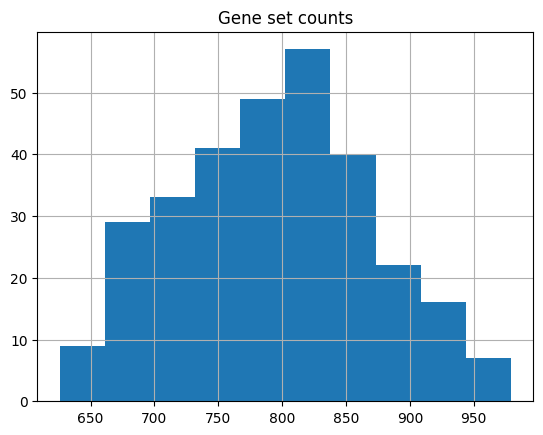

In [11]:
pd.Series(gene_set_sizes).hist()
plt.title("Gene set counts")

In [12]:
with open("../output/serine_threonine_kinome_atlas_2023.gmt", "w") as o:
    for k,v in gmt.items():
        row = [k, ""] + v
        o.write("\t".join(row))
        o.write("\n")